In [205]:
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [157]:
train = pd.read_csv('C:/Users/tmdwh/Desktop/SEUNGJO/dacon/competition_data/train.csv')
test = pd.read_csv('C:/Users/tmdwh/Desktop/SEUNGJO/dacon/competition_data/test.csv')
submission = pd.read_csv('C:/Users/tmdwh/Desktop/SEUNGJO/dacon/competition_data/submission.csv', index_col = 0)

In [158]:
# 결측치 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 70 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         15000 non-null  int64  
 1   Q1            14959 non-null  float64
 2   Q2            14931 non-null  float64
 3   Q3            14950 non-null  float64
 4   Q4            14929 non-null  float64
 5   Q5            14962 non-null  float64
 6   Q6            14952 non-null  float64
 7   Q7            14924 non-null  float64
 8   Q8            14952 non-null  float64
 9   Q9            14944 non-null  float64
 10  Q10           14928 non-null  float64
 11  Q11           14941 non-null  float64
 12  Q12           14933 non-null  float64
 13  Q13           14960 non-null  float64
 14  Q14           14964 non-null  float64
 15  Q15           14955 non-null  float64
 16  Q16           14967 non-null  float64
 17  Q17           14963 non-null  float64
 18  Q18           14937 non-nu

In [159]:
#nan값 전부 0으로 삽입
train.fillna(0, inplace= True)
test.fillna(0, inplace= True)

In [160]:
#상관관계가 적은 시간 특성, 인덱스 col을 제거

drop_list = ['introelapse', 'testelapse', 'surveyelapse', 'index',]

train.drop(drop_list, axis = 1, inplace = True)
test.drop(drop_list, axis = 1, inplace = True)

In [161]:
#0값을 해당 특성의 train의 평균값으로 처리
processing_feature = ['gender', 'married', 'education', 'voted', 'urban', 'orientation', 'religion', 'engnat', 'ASD']

for pro in processing_feature:
    train.loc[train[pro] == 0, pro] = train[pro].mean()
    test.loc[test[pro] == 0, pro] = train[pro].mean()

"\ncategorical_columns = ['gender', 'married', 'education', 'voted', 'urban', 'orientation', 'religion', 'engnat']\n\nfor category in categorical_columns:\n    train.loc[train[category] == 0, category] = train[category].mean()\n    test.loc[test[category] == 0, category] = test[category].mean()\n    "

In [162]:
#age 이상치(80살 이상) 0으로 처리
train.loc[train['age'] > 80, 'age'] = 0
test.loc[test['age'] > 80, 'age'] = 0

In [163]:
#age의 이상치는 train데이터의 평균값으로 처리
train.loc[train['age'] == 0, 'age'] = train['age'].mean()
test.loc[test['age'] == 0, 'age'] = train['age'].mean()

#familysize 6 이상인 값 최빈값으로 교체, 
train.loc[train['familysize'] > 6, 'familysize'] = train['familysize'].mode()[0]
test.loc[test['familysize'] > 6, 'familysize'] = train['familysize'].mode()[0]

In [164]:
# 훈련 데이터에 존재하는 상위 6개의 나라
top6_country = train['country'].value_counts().keys()[:6]

# train데이터 상위 6개 국가 제외 train데이터의 최빈값으로 처리
for i in range(len(train['country'])):
    if train['country'][i] not in top6_country or train['country'][i]==0:
        train['country'][i] = train['country'].mode()[0]

# test데이터 상위 6개 국가 제외 train데이터의 최빈값으로 처리
for i in range(len(test['country'])):
    if test['country'][i] not in top6_country or test['country'][i]==0:
        test['country'][i] = train['country'].mode()[0]

c:\Users\tmdwh\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
c:\Users\tmdwh\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [165]:
#country 특성 원-핫인코딩 수행 (country 특성 세부 분할)
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [166]:
train.columns

Index(['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11',
       'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21',
       'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'TIPI1', 'TIPI2', 'TIPI3', 'TIPI4',
       'TIPI5', 'TIPI6', 'TIPI7', 'TIPI8', 'TIPI9', 'TIPI10', 'VCL1', 'VCL2',
       'VCL3', 'VCL4', 'VCL5', 'VCL6', 'VCL7', 'VCL8', 'VCL9', 'VCL10',
       'VCL11', 'VCL12', 'VCL13', 'VCL14', 'VCL15', 'VCL16', 'education',
       'urban', 'gender', 'engnat', 'age', 'hand', 'religion', 'orientation',
       'voted', 'married', 'familysize', 'ASD', 'nerdiness', 'country_AUS',
       'country_CAN', 'country_DEU', 'country_GBR', 'country_PHL',
       'country_USA'],
      dtype='object')

In [167]:
# 마키아벨리즘에 대한 질문 점수
makia_survey = ['Q' + str(i+1) for i in range(20)]
not_makia = ['Q3', 'Q4', 'Q6','Q7', 'Q9', 'Q10', 'Q11', 'Q14', 'Q16', 'Q17', 'Q18']
# 'Q6', 'Q14', 'Q18'
# 'Q21', 'Q22', 'Q23', 'Q23', 'Q24', 'Q25', 'Q26'은 secret question이라 제외

for columns in not_makia:
    train.loc[train[columns] > 0, columns] = 6 - train[columns]
    test.loc[test[columns] > 0, columns] = 6 - test[columns]



# 기준치 (60점 이상)에 관련된 파생변수 생성
train['makia_score'] = np.sum(train[makia_survey], axis = 1)
test['makia_score'] = np.sum(test[makia_survey], axis = 1)

train['high_makia'] = train['makia_score'].apply(lambda x : (1 if x > 60 else 0))
test['high_makia'] = test['makia_score'].apply(lambda x : (1 if x > 60 else 0))

In [168]:
'''
 TIPI에 대한 질문 점수
 TIPI는 1 ~ 7점까지 존재 -> 1 ~ 5점으로 변환
 TIPI 1점 -> 1점
 TIPI 2점 -> 2점
 TIPI 3점 -> 3점
 TIPI 4점 -> 3점
 TIPI 5점 -> 3점
 TIPI 6점 -> 4점 
 TIPI 7점 -> 5점
'''
TIPI_columns = ['TIPI' + str(x + 1) for x in range(10)]
TIPI_score = {1:1, 2:2, 3:4, 3:5, 4:6, 5:7}


for tipi in TIPI_columns:
    train[tipi] = train[tipi].map(TIPI_score)
    test[tipi] = test[tipi].map(TIPI_score)

train[TIPI_columns].describe()

Index(['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11',
       'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21',
       'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'TIPI1', 'TIPI2', 'TIPI3', 'TIPI4',
       'TIPI5', 'TIPI6', 'TIPI7', 'TIPI8', 'TIPI9', 'TIPI10', 'VCL1', 'VCL2',
       'VCL3', 'VCL4', 'VCL5', 'VCL6', 'VCL7', 'VCL8', 'VCL9', 'VCL10',
       'VCL11', 'VCL12', 'VCL13', 'VCL14', 'VCL15', 'VCL16', 'education',
       'urban', 'gender', 'engnat', 'age', 'hand', 'religion', 'orientation',
       'voted', 'married', 'familysize', 'ASD', 'nerdiness', 'country_AUS',
       'country_CAN', 'country_DEU', 'country_GBR', 'country_PHL',
       'country_USA'],
      dtype='object')

In [169]:
test[TIPI_columns].describe()

In [170]:
'''
TIPI 관련 파생변수 생성

성실성 : {3번 점수 + (8 - '8번 점수')} ÷ 2
우호성 : {7번 점수 + (8 - '2번 점수')} ÷ 2
정서적 안정성(점수가 낮으면 신경성과 관련): {9번 점수 + (8 - '4번 점수')} ÷ 2
개방성 : {5번 점수 + (8 - '10번 점수')} ÷ 2
외향성 : {1번 점수 + (8 - '6번 점수')} ÷ 2
'''

train['diligence'] = (train['TIPI3'] + 8 - train['TIPI8']) / 2
train['friendliness'] = (train['TIPI7'] + 8- train['TIPI2']) / 2
train['stability'] = (train['TIPI9'] + 8 - train['TIPI4']) / 2
train['openness'] = (train['TIPI5'] + 8 - train['TIPI10']) / 2
train['extroversion'] = (train['TIPI1'] + 8 - train['TIPI6']) / 2


test['diligence'] = (test['TIPI3'] + 8 - test['TIPI8']) / 2
test['friendliness'] = (test['TIPI7'] + 8- test['TIPI2']) / 2
test['stability'] = (test['TIPI9'] + 8 - test['TIPI4']) / 2
test['openness'] = (test['TIPI5'] + 8 - test['TIPI10']) / 2
test['extroversion'] = (test['TIPI1'] + 8 - test['TIPI6']) / 2

,TIPI1,TIPI2,TIPI3,TIPI4,TIPI5,TIPI6,TIPI7,TIPI8,TIPI9,TIPI10
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,3.751267,4.563400,5.229400,4.851333,5.795333,5.463467,5.312800,4.520667,4.739667,3.012867
std,2.054510,1.802091,1.500975,1.870044,1.140087,1.590357,1.487157,1.904297,1.760180,1.948270
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,2.000000,5.000000,1.000000
50%,5.000000,5.000000,5.000000,5.000000,6.000000,6.000000,5.000000,5.000000,5.000000,2.000000
75%,5.000000,6.000000,6.000000,6.000000,7.000000,7.000000,6.000000,6.000000,6.000000,5.000000
max,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000


In [171]:
# EDA 결과 50대 이상일수록 nerdiness가 1인 비율이 많아짐. => 관련 파생변수 생성
def age_to_category(age):
    normalize = age // 10
    if normalize == 1:
        return 'children'
    elif (normalize >= 2) & (normalize <= 3):
        return 'adult'
    elif (normalize >= 4) & (normalize <= 6):
        return 'middle age'
    else:
        return 'old age'

,TIPI1,TIPI2,TIPI3,TIPI4,TIPI5,TIPI6,TIPI7,TIPI8,TIPI9,TIPI10
count,35452.000000,35452.000000,35452.000000,35452.000000,35452.000000,35452.000000,35452.000000,35452.000000,35452.000000,35452.000000
mean,3.738153,4.527897,5.200468,4.840742,5.802663,5.468070,5.316315,4.535372,4.749662,2.978816
std,2.065309,1.817297,1.526410,1.873197,1.139026,1.575324,1.510887,1.903089,1.768045,1.945080
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,2.000000,5.000000,1.000000
50%,5.000000,5.000000,5.000000,5.000000,6.000000,6.000000,5.000000,5.000000,5.000000,2.000000
75%,5.000000,6.000000,6.000000,6.000000,7.000000,7.000000,6.000000,6.000000,6.000000,5.000000
max,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000


In [172]:
train['age_category'] = train['age'].apply(lambda x : age_to_category(x))
counts = train.groupby('age_category')['nerdiness'].value_counts(normalize = True).rename('percentage').mul(100).reset_index()
sns.barplot(x = 'age_category', y = 'percentage', hue = 'nerdiness', data = counts)
test['age_category'] = test['age'].apply(lambda x : age_to_category(x))


In [173]:
#age 특성 원-핫인코딩 수행 (age 특성 세부 분할)
train = pd.get_dummies(train)
test = pd.get_dummies(test)

train.columns

In [174]:
# 특정 종교와 관련하여 nerdiness 변화가 뚜렷함.
def convert_environment(x):
    if ((x == '2.0') | (x == '5.0') | (x == '9.0')):
        return 0
    elif ((x == '1.0') | (x == '12.0') | (x == '6.0') | (x == '7.0')):
        return 1
    else:
        return 2


train['religion_environment'] = train['religion'].apply(lambda x : convert_environment(x))
test['religion_environment'] = test['religion'].apply(lambda x : convert_environment(x))

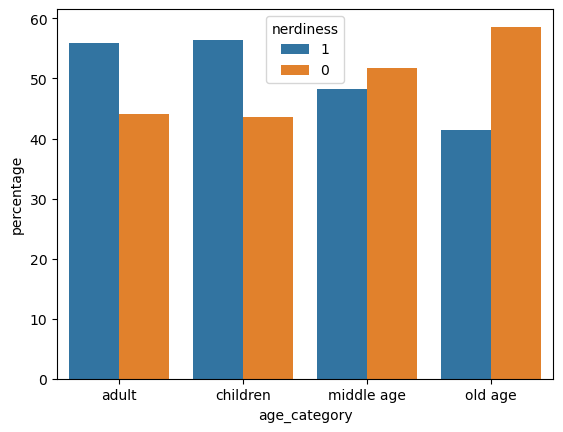

In [175]:
# age, religion -> 삭제
train.drop(['age', 'religion'], axis = 1, inplace = True)
test.drop(['age', 'religion'], axis = 1, inplace = True)

In [176]:
train.info()

0        20.0
1        49.0
2        43.0
3        17.0
4        18.0
         ... 
14995    17.0
14996    45.0
14997    20.0
14998    29.0
14999    21.0
Name: age, Length: 15000, dtype: float64

In [177]:
train.isnull().sum()

In [178]:
train.head()

In [179]:
train.columns

In [ ]:
!pip install --quiet optuna

KeyboardInterrupt: 

In [180]:
import numpy as np
import pandas as pd
import optuna
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from optuna.samplers import TPESampler
from optuna.pruners import SuccessiveHalvingPruner

Index(['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11',
       'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21',
       'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'TIPI1', 'TIPI2', 'TIPI3', 'TIPI4',
       'TIPI5', 'TIPI6', 'TIPI7', 'TIPI8', 'TIPI9', 'TIPI10', 'VCL1', 'VCL2',
       'VCL3', 'VCL4', 'VCL5', 'VCL6', 'VCL7', 'VCL8', 'VCL9', 'VCL10',
       'VCL11', 'VCL12', 'VCL13', 'VCL14', 'VCL15', 'VCL16', 'education',
       'urban', 'gender', 'engnat', 'hand', 'orientation', 'voted', 'married',
       'familysize', 'ASD', 'nerdiness', 'country_AUS', 'country_CAN',
       'country_DEU', 'country_GBR', 'country_PHL', 'country_USA',
       'makia_score', 'high_makia', 'diligence', 'friendliness', 'stability',
       'openness', 'extroversion', 'Tactics', 'Views', 'Morality',
       'age_category', 'religion_environment'],
      dtype='object')

In [181]:
features = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11',
       'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21',
       'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'TIPI1', 'TIPI2', 'TIPI3', 'TIPI4',
       'TIPI5', 'TIPI6', 'TIPI7', 'TIPI8', 'TIPI9', 'TIPI10', 'VCL1', 'VCL2',
       'VCL3', 'VCL4', 'VCL5', 'VCL6', 'VCL7', 'VCL8', 'VCL9', 'VCL10',
       'VCL11', 'VCL12', 'VCL13', 'VCL14', 'VCL15', 'VCL16', 'education',
       'urban', 'gender', 'engnat', 'hand', 'orientation', 'voted', 'married',
       'familysize', 'ASD', 'country_AUS', 'country_CAN',
       'country_DEU', 'country_GBR', 'country_PHL', 'country_USA',
       'makia_score', 'high_makia', 'diligence', 'friendliness', 'stability',
       'openness', 'extroversion', 'age_category_adult',
       'age_category_children', 'age_category_middle age',
       'age_category_old age', 'religion_environment']

target = ['nerdiness']

'\n# 위의 방식을 사용하여 연속형 변수 이상치(outlier) 처리\nfor time_columns in time:\n    q1 = np.percentile(train[time_columns], 25)\n    q3 = np.percentile(test[time_columns], 75)\n\n    outlier_bounds = q3 + 1.5 * (q3 - q3)\n    train.loc[train[time_columns] >= outlier_bounds, time_columns] = outlier_bounds\n    test.loc[test[time_columns] >= outlier_bounds, time_columns] = outlier_bounds\n\ntrain[time].describe()\n'

In [182]:
df_trains = []
df_valids = []

skf = StratifiedKFold(n_splits=10, random_state=2022, shuffle=True)
for train_index, valid_index in skf.split(train[features], train[target]):
    df_train = train.loc[train_index]
    df_valid = train.loc[valid_index]
    df_trains.append(df_train)
    df_valids.append(df_valid)

    x_train = df_train[features]
    y_train = df_train[target]

    x_test = df_valid[features]
    y_test = df_valid[target]

"\n# train data에 존재하는 상위 6개 나라\nbest_country = train['country'].value_counts().keys()[:6]\n\n# best country가 아닌 국가는 최빈값으로 처리\nfor i in range(len(train['country'])):\n    if train['country'][i] not in best_country or train['country'][i] == 0:\n        train['country'][i] = train['country'].mode()[0]\n        \n# test data도 동일하게 처리\nfor i in range(len(test['country'])):\n    if test['country'][i] not in best_country or test['country'][i] == 0:\n        test['country'][i] = train['country'].mode()[0]\n"

In [183]:
def accuracy(true, pred):
    return np.mean(true==pred)

def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 300, 824, step=1, log=True), 
        'max_depth': trial.suggest_int('max_depth', 10, 20, step=1, log=False), 
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.1, log=True), 
        'n_estimators': trial.suggest_int('n_estimators', 1500, 3000, step=1, log=True), 
        "metric": "multi_auc",
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50, step=1, log=False), 
        'subsample': trial.suggest_uniform('subsample', 0.7, 1.0), 
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 1.0),
        'random_state': 2022
    }
    
    score = []
    for df_train, df_valid in zip(df_trains, df_valids):
        clf = LGBMClassifier(**params)
        clf.fit(x_train, y_train)
        
        pred = clf.predict_proba(df_valid[features])[:, 1]
        true = df_valid[target].values
        score.append(roc_auc_score(true, pred))
    score = np.mean(score)
    return score

# Hyperparameter Tuning
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=2022), pruner=SuccessiveHalvingPruner())
study.optimize(objective, n_trials=10)

Index(['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11',
       'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21',
       'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'TIPI1', 'TIPI2', 'TIPI3', 'TIPI4',
       'TIPI5', 'TIPI6', 'TIPI7', 'TIPI8', 'TIPI9', 'TIPI10', 'VCL1', 'VCL2',
       'VCL3', 'VCL4', 'VCL5', 'VCL6', 'VCL7', 'VCL8', 'VCL9', 'VCL10',
       'VCL11', 'VCL12', 'VCL13', 'VCL14', 'VCL15', 'VCL16', 'education',
       'urban', 'gender', 'engnat', 'hand', 'orientation', 'voted', 'married',
       'familysize', 'ASD', 'nerdiness', 'country_AUS', 'country_CAN',
       'country_DEU', 'country_GBR', 'country_PHL', 'country_USA',
       'makia_score', 'high_makia', 'diligence', 'friendliness', 'stability',
       'openness', 'extroversion', 'Tactics', 'Views', 'Morality',
       'age_category', 'religion_environment'],
      dtype='object')

In [184]:
optuna.visualization.plot_optimization_history(study)

In [185]:
optuna.visualization.plot_parallel_coordinate(study)

(12, 54)

In [186]:
# 하이퍼파라미터 중요도
optuna.visualization.plot_param_importances(study)

Index(['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11',
       'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21',
       'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'TIPI1', 'TIPI2', 'TIPI3', 'TIPI4',
       'TIPI5', 'TIPI6', 'TIPI7', 'TIPI8', 'TIPI9', 'TIPI10', 'education',
       'urban', 'gender', 'engnat', 'hand', 'orientation', 'voted', 'married',
       'familysize', 'ASD', 'nerdiness', 'country_AUS', 'country_CAN',
       'country_DEU', 'country_GBR', 'country_PHL', 'country_USA',
       'makia_score', 'high_makia', 'diligence', 'friendliness', 'stability',
       'openness', 'extroversion', 'Tactics', 'Views', 'Morality',
       'age_category', 'religion_environment', '지능', 'fake'],
      dtype='object')

In [187]:
clfs = []
for df_train in df_trains:
    clf = LGBMClassifier(**study.best_params)
    clf.fit(df_train[features], df_train[target])
    pred_clf = clf.predict_proba(x_test)[:, 1]
    print(roc_auc_score(y_test, pred_clf))
    clfs.append(clf)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 67 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Q1                    15000 non-null  float32
 1   Q2                    15000 non-null  float32
 2   Q3                    15000 non-null  float32
 3   Q4                    15000 non-null  float32
 4   Q5                    15000 non-null  float32
 5   Q6                    15000 non-null  float32
 6   Q7                    15000 non-null  float32
 7   Q8                    15000 non-null  float32
 8   Q9                    15000 non-null  float32
 9   Q10                   15000 non-null  float32
 10  Q11                   15000 non-null  float32
 11  Q12                   15000 non-null  float32
 12  Q13                   15000 non-null  float32
 13  Q14                   15000 non-null  float32
 14  Q15                   15000 non-null  float32
 15  Q16                

In [188]:
clfs

In [190]:
pred = [clf.predict_proba(test[features]) for clf in clfs]

In [ ]:
for numeric in numeric_columns:
    print('{0} column의 왜도 {1:.4f}'.format(numeric, train[numeric].skew()))


Q1 column의 왜도 -0.9885
Q2 column의 왜도 -1.1972
Q3 column의 왜도 1.4591
Q4 column의 왜도 0.7707
Q5 column의 왜도 -0.9031
Q6 column의 왜도 0.6339
Q7 column의 왜도 1.3420
Q8 column의 왜도 -0.9678
Q9 column의 왜도 0.9139
Q10 column의 왜도 1.1142
Q11 column의 왜도 0.1606
Q12 column의 왜도 -0.8517
Q13 column의 왜도 -0.6511
Q14 column의 왜도 0.5904
Q15 column의 왜도 -0.0703
Q16 column의 왜도 0.3775
Q17 column의 왜도 0.8841
Q18 column의 왜도 1.0026
Q19 column의 왜도 -0.3849
Q20 column의 왜도 -0.4999
Q21 column의 왜도 -0.0159
Q22 column의 왜도 0.5872
Q23 column의 왜도 -0.9040
Q24 column의 왜도 -1.4714
Q25 column의 왜도 -0.1770
Q26 column의 왜도 -1.2057
TIPI1 column의 왜도 -0.1143
TIPI2 column의 왜도 -0.8614
TIPI3 column의 왜도 -1.3360
TIPI4 column의 왜도 -0.9022
TIPI5 column의 왜도 -1.4917
TIPI6 column의 왜도 -1.4152
TIPI7 column의 왜도 -1.3476
TIPI8 column의 왜도 -0.7215
TIPI9 column의 왜도 -0.9172
TIPI10 column의 왜도 0.3571
familysize column의 왜도 1.1519
country_AUS column의 왜도 5.0609
country_CAN column의 왜도 3.6689
country_DEU column의 왜도 5.3620
country_GBR column의 왜도 3.2569
country_PHL column의 왜도 7

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train[numeric_columns])
x_scaled = pd.DataFrame(scaler.transform(train[numeric_columns]), columns = numeric_columns)
x_test_scaled = pd.DataFrame(scaler.transform(train[numeric_columns]), columns = numeric_columns)

train_data = pd.concat([train[categorical_columns], x_scaled], axis = 1)
test_data = pd.concat([test[categorical_columns], x_test_scaled], axis = 1)
train_data.shape, test_data.shape

((15000, 66), (35452, 66))

In [ ]:
train.drop(['high_makia', 'ASD'], axis = 1, inplace = True)
test.drop(['high_makia', 'ASD'], axis = 1, inplace = True)

KeyError: "['high_makia' 'ASD'] not found in axis"

In [ ]:
#nan 값을 전부 0으로 처리
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 65 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Q1                    15000 non-null  float32
 1   Q2                    15000 non-null  float32
 2   Q3                    15000 non-null  float32
 3   Q4                    15000 non-null  float32
 4   Q5                    15000 non-null  float32
 5   Q6                    15000 non-null  float32
 6   Q7                    15000 non-null  float32
 7   Q8                    15000 non-null  float32
 8   Q9                    15000 non-null  float32
 9   Q10                   15000 non-null  float32
 10  Q11                   15000 non-null  float32
 11  Q12                   15000 non-null  float32
 12  Q13                   15000 non-null  float32
 13  Q14                   15000 non-null  float32
 14  Q15                   15000 non-null  float32
 15  Q16                

In [202]:
label_categorical_columns = ['urban', 'gender', 'engnat', 'hand','voted', 'married', 'age_category', 'religion_environment'] + question_columns
onehot_categorical_columns = ['education', 'orientation']
categorical_columns = [] + label_categorical_columns + onehot_categorical_columns
numerical_columns = [columns for columns in train.columns if columns not in ([] + label_categorical_columns + onehot_categorical_columns)]


print('label : ', label_categorical_columns)
print('one hot : ', onehot_categorical_columns)
print('category : ', categorical_columns)
print('numeric : ', numeric_columns)


label :  ['urban', 'gender', 'engnat', 'hand', 'voted', 'married', 'age_category', 'religion_environment', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26']
one hot :  ['education', 'orientation']
category :  ['urban', 'gender', 'engnat', 'hand', 'voted', 'married', 'age_category', 'religion_environment', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'education', 'orientation']
numeric :  Index(['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11',
       'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21',
       'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'TIPI1', 'TIPI2', 'TIPI3', 'TIPI4',
       'TIPI5', 'TIPI6', 'TIPI7', 'TIPI8', 'TIPI9', 'TIPI10', 'familysize',
       'country_AUS', 'country_CAN', 'country_DEU', 

In [203]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


label_categorical_columns = ['urban', 'gender', 'engnat', 'hand','voted', 'married', 'age_category', 'religion_environment', 'education', 'orientation'] + question_columns
categorical_columns = [] + label_categorical_columns
numerical_columns = [columns for columns in train.columns if columns not in ([] + label_categorical_columns)]

for label in label_categorical_columns:
    le = LabelEncoder()
    le.fit(train_data[label])
    train_data[label] = le.transform(train_data[label])
    test_data[label] = le.transform(test_data[label])



ValueError: y contains previously unseen labels: [-2.711132155227061, -1.7983545122309461, -0.885576869234831, 0.02720077376128407, 0.9399784167573991, nan]

여기서부터는 모델


In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


label_categorical_columns = ['urban', 'gender', 'engnat', 'hand','voted', 'married', 'age_category', 'religion_environment'] + question_columns
onehot_categorical_columns = ['education', 'orientation']
categorical_columns = [] + label_categorical_columns + onehot_categorical_columns
numerical_columns = [columns for columns in train.columns if columns not in ([] + label_categorical_columns + onehot_categorical_columns)]

for label in label_categorical_columns:
    le = LabelEncoder()
    le.fit(train_data[label])
    train_data[label] = le.transform(train_data[label])
    test_data[label] = le.transform(test_data[label])

for onehot in onehot_categorical_columns:
    train_data = pd.get_dummies(train_data, columns = [onehot])
    test_data = pd.get_dummies(test_data, columns = [onehot])

ValueError: y contains previously unseen labels: [-2.711132155227061, -1.7983545122309461, -0.885576869234831, 0.02720077376128407, 0.9399784167573991, nan]

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score

X = train_data
y = train['nerdiness']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size= 0.2, random_state = 42, stratify = y)

In [ ]:
from sklearn.model_selection import StratifiedKFold
def tune_model(model_type, X, Y, n_trials=100, cv=10):
    skf = StratifiedKFold(n_splits=cv)
    
    if model_type=='lgb':
        def objective(trial):
            n_estimators = trial.suggest_int('n_estimators', 100, 1000)
            learning_rate = trial.suggest_loguniform('learning_rate', 0.05, 0.3)
            num_leaves = trial.suggest_int('num_leaves', 7, 255)
            reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-4, 10)
            reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-4, 10)
            colsample_bytree = trial.suggest_uniform('colsample_bytree', 0, 1)
            subsample = trial.suggest_uniform('subsample', 0, 1)
            params = {'n_estimators' : n_estimators, 
                     'learning_rate' : learning_rate, 
                      'num_leaves' : num_leaves,
                     'reg_alpha' : reg_alpha,
                     'reg_lambda' : reg_lambda, 
                     'colsample_bytree' : colsample_bytree, 
                     'subsample' : subsample
                     }
            model = lgb.LGBMClassifier(metric='auc', random_state=42, **params)
            score = cross_val_score(model, X, Y, cv=skf, scoring='roc_auc').mean()
            
            return score
    
        
    elif model_type=='rf':
        def objective(trial):
            n_estimators = trial.suggest_int('n_estimators', 100, 1000)
            max_depth = trial.suggest_int('max_depth', 3, 100)
            max_features = trial.suggest_uniform('max_features', 0, 1)
            criterion = trial.suggest_categorical('criterion', ['gini','entropy'])
            params = {'n_estimators' : n_estimators, 
                     'max_features' : max_features, 
                      'max_depth' : max_depth,
                      'criterion' : criterion
                     }
            model = RandomForestClassifier(random_state=42, **params, n_jobs=-1)
            score = cross_val_score(model, X, Y, cv=skf, scoring='roc_auc').mean()
            
            return score
        
        
    elif model_type=='ets':
        def objective(trial):
            n_estimators = trial.suggest_int('n_estimators', 100, 1000)
            max_depth = trial.suggest_int('max_depth', 3, 100)
            max_features = trial.suggest_uniform('max_features', 0, 1)
            criterion = trial.suggest_categorical('criterion', ['gini','entropy'])
            params = {'n_estimators' : n_estimators, 
                     'max_features' : max_features, 
                      'max_depth' : max_depth,
                      'criterion' : criterion
                     }
            model = ExtraTreesClassifier(random_state=42, **params, n_jobs=-1)
            score = cross_val_score(model, X, Y, cv=skf, scoring='roc_auc').mean()
            
            return score
        
    
    sampler = TPESampler(seed=42)
    study=optuna.create_study(direction='maximize', 
                              sampler = sampler)
    study.optimize(objective, n_trials=n_trials)
    print(f"Model : {model_type}, Best Score : {study.best_value}, Best Params : {study.best_params}")
    return study.best_params

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier, RandomForestClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score

ex_params = {'n_estimators': 500, 'max_depth': 75, 'max_features': 0.20222465942018208, 'criterion': 'entropy'}
rf_params =  {'n_estimators': 400, 'max_depth': 31, 'max_features': 0.05408093225447195, 'criterion': 'entropy'}
lgb_params = {'n_estimators': 189, 'learning_rate': 0.06550029428021084, 'num_leaves': 249, 'reg_alpha': 0.00011906936480932443, 'reg_lambda': 0.00012169645168232884, 'colsample_bytree': 0.2231374650653746, 'subsample': 0.18089704448751198}

ex_clf = ExtraTreesClassifier(**ex_params, random_state = 42)
rf_clf = RandomForestClassifier(**rf_params, random_state = 42)
tuned_lgbm=lgb.LGBMClassifier(objective="binary", random_state=42, **lgb_params)

vt_clf = VotingClassifier(estimators = [
        ('lgbm', tuned_lgbm),
        ('rf', rf_clf),
        ('ex', ex_clf),
    ], weights = (2, 1, 7), voting = 'soft')

score = cross_val_score(vt_clf, X, y, cv = 10, scoring = 'roc_auc')
score.mean(), score.std()

(0.8921728717266963, 0.011232984601497732)

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier, RandomForestClassifier
import lightgbm as lgb

ex_params = {'n_estimators': 500, 'max_depth': 75, 'max_features': 0.20222465942018208, 'criterion': 'entropy'}
rf_params =  {'n_estimators': 400, 'max_depth': 31, 'max_features': 0.05408093225447195, 'criterion': 'entropy'}
lgb_params = {'n_estimators': 189, 'learning_rate': 0.06550029428021084, 'num_leaves': 249, 'reg_alpha': 0.00011906936480932443, 'reg_lambda': 0.00012169645168232884, 'colsample_bytree': 0.2231374650653746, 'subsample': 0.18089704448751198}

ex_clf = ExtraTreesClassifier(**ex_params, random_state = 42)
rf_clf = RandomForestClassifier(**rf_params, random_state = 42)
tuned_lgbm=lgb.LGBMClassifier(objective="binary", random_state=42, **lgb_params)

vt_clf = VotingClassifier(estimators = [
        ('lgbm', tuned_lgbm),
        ('rf', rf_clf),
        ('ex', ex_clf),
    ], weights = (2, 1, 7), voting = 'soft')

vt_clf.fit(X, y)

predictions = vt_clf.predict_proba(test_data)[:, 1]
submission['nerdiness'] = predictions
submission

,index,nerdiness
0,0,0.093751
1,1,0.796669
2,2,0.884768
3,3,0.577233
4,4,0.956298
...,...,...
35447,35447,0.959114
35448,35448,0.739745
35449,35449,0.951074
35450,35450,0.056970


In [ ]:
# !pip install optuna
# optuna를 사용하여 하이퍼 파라미터 최적화

import optuna
from optuna import Trial
from optuna.samplers import TPESampler

In [ ]:
from sklearn.model_selection import StratifiedKFold
def tune_model(model_type, X, Y, n_trials=100, cv=10):
    skf = StratifiedKFold(n_splits=cv)
    
    if model_type=='lgb':
        def objective(trial):
            n_estimators = trial.suggest_int('n_estimators', 100, 1000)
            learning_rate = trial.suggest_loguniform('learning_rate', 0.05, 0.3)
            num_leaves = trial.suggest_int('num_leaves', 7, 255)
            reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-4, 10)
            reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-4, 10)
            colsample_bytree = trial.suggest_uniform('colsample_bytree', 0, 1)
            subsample = trial.suggest_uniform('subsample', 0, 1)
            params = {'n_estimators' : n_estimators, 
                     'learning_rate' : learning_rate, 
                      'num_leaves' : num_leaves,
                     'reg_alpha' : reg_alpha,
                     'reg_lambda' : reg_lambda, 
                     'colsample_bytree' : colsample_bytree, 
                     'subsample' : subsample
                     }
            model = lgb.LGBMClassifier(metric='auc', random_state=42, **params)
            score = cross_val_score(model, X, Y, cv=skf, scoring='roc_auc').mean()
            
            return score
    
#     elif model_type=='cat':
#         def objective(trial):
#             params={}
#             params['n_estimators'] = trial.suggest_int('n_estimators', 100, 1000)
#             params['learning_rate'] = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
#             params['depth'] = trial.suggest_int('depth', 3, 8)
#             params['reg_lambda'] = trial.suggest_loguniform('reg_lambda', 1e-4, 30)
#             params['random_strength'] = trial.suggest_uniform('random_strength', 0.1, 30)
            
#             params['bootstrap_type'] = trial.suggest_categorical('bootstrap_type', ['Bayesian','Bernoulli','Poisson'])
#             if params['bootstrap_type'] == 'Bayesian':
#                 params['bagging_temperature'] = trial.suggest_uniform('bagging_temperature', 0, 30)
#             else: 
#                 params['subsample'] = trial.suggest_uniform('subsample', 0, 1)
#             print(params)
#             model = CatBoostClassifier(task_type="GPU", eval_metric='AUC', random_seed=42, **params, verbose=False)
#             model.fit(x_train, y_train, early_stopping_rounds=100, verbose=500, eval_set=(x_test, y_test))
#             score = roc_auc_score(y_test, model.predict_proba(x_test)[:,1])

#             return score
        
        
    elif model_type=='rf':
        def objective(trial):
            n_estimators = trial.suggest_int('n_estimators', 100, 1000)
            max_depth = trial.suggest_int('max_depth', 3, 100)
            max_features = trial.suggest_uniform('max_features', 0, 1)
            criterion = trial.suggest_categorical('criterion', ['gini','entropy'])
            params = {'n_estimators' : n_estimators, 
                     'max_features' : max_features, 
                      'max_depth' : max_depth,
                      'criterion' : criterion
                     }
            model = RandomForestClassifier(random_state=42, **params, n_jobs=-1)
            score = cross_val_score(model, X, Y, cv=skf, scoring='roc_auc').mean()
            
            return score
        
        
    elif model_type=='ets':
        def objective(trial):
            n_estimators = trial.suggest_int('n_estimators', 100, 1000)
            max_depth = trial.suggest_int('max_depth', 3, 100)
            max_features = trial.suggest_uniform('max_features', 0, 1)
            criterion = trial.suggest_categorical('criterion', ['gini','entropy'])
            params = {'n_estimators' : n_estimators, 
                     'max_features' : max_features, 
                      'max_depth' : max_depth,
                      'criterion' : criterion
                     }
            model = ExtraTreesClassifier(random_state=42, **params, n_jobs=-1)
            score = cross_val_score(model, X, Y, cv=skf, scoring='roc_auc').mean()
            
            return score
        
    
    sampler = TPESampler(seed=42)
    study=optuna.create_study(direction='maximize', 
                              sampler = sampler)
    study.optimize(objective, n_trials=n_trials)
    print(f"Model : {model_type}, Best Score : {study.best_value}, Best Params : {study.best_params}")
    return study.best_params

In [ ]:
lgb_params = tune_model('lgb', X, y, n_trials=10)

[I 2023-01-11 00:32:44,280] Trial 0 finished with value: 0.8270957717078261 and parameters: {'n_estimators': 202, 'learning_rate': 0.2083535600888856, 'num_leaves': 21, 'reg_alpha': 0.4570563099801455, 'reg_lambda': 0.09846738873614563, 'colsample_bytree': 0.15601864044243652, 'subsample': 0.15599452033620265}. Best is trial 0 with value: 0.8270957717078261.
[I 2023-01-11 00:32:51,839] Trial 1 finished with value: 0.7986779746086973 and parameters: {'n_estimators': 430, 'learning_rate': 0.1138505423634207, 'num_leaves': 123, 'reg_alpha': 0.10129197956845731, 'reg_lambda': 0.3470266988650412, 'colsample_bytree': 0.020584494295802447, 'subsample': 0.9699098521619943}. Best is trial 0 with value: 0.8270957717078261.
[I 2023-01-11 00:33:48,778] Trial 2 finished with value: 0.8802643601186138 and parameters: {'n_estimators': 591, 'learning_rate': 0.26872369865333173, 'num_leaves': 136, 'reg_alpha': 0.0008111941985431928, 'reg_lambda': 0.0008260808399079611, 'colsample_bytree': 0.30424224295

In [ ]:
rf_params = tune_model('rf', X, y, n_trials=300)

In [ ]:
ets_parm= tune_model('ets', X, y, n_trials=300)